In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from statsmodels.stats.proportion import proportions_ztest

Продакт-менеджер решил поменять формулировку вопроса о стоимости, которую клиент готов платить спортивному тренеру.
Это один из самых сложных вопросов при создании заказа, потому что клиент часто не знает, сколько стоит услуга и ему трудно заполнить это поле. В то же время информация о том, сколько готов заплатить клиент, важна для определения процента, который компания получит с этого заказа. В компании уже были тесты, которые показывали, что формулировки вопросов сильно влияют на ответы пользователей. 

Для более точной оценки заказа было решено задавать не просто вопрос “Подходящая стоимость занятия”, а “Подходящая стоимость за час занятия”. Вот так выглядели варианты теста:


## Часть 1
### Расчет длительности эксперемента и сбор данных 

В эксперименте договорились следить, как изменится конверсия в заказ и стоимость заказа. В файле practice_1_2.xlsx приведены данные по количеству пользователей и заказов с 1 июня 2018 года по 1 августа 2018 года. Рассчитайте длительность эксперимента на основе имеющихся данных. 

In [3]:
df = pd.read_excel('practice_1_2.xlsx')

In [50]:
df.head()

,date,users,orders
0,2018-06-01,2580,710
1,2018-06-02,2603,676
2,2018-06-03,2615,712
3,2018-06-04,2627,663
4,2018-06-05,2530,727


In [52]:
df['conv'] = df.orders / df.users
df.head()

,date,users,orders,conv
0,2018-06-01,2580,710,0.275194
1,2018-06-02,2603,676,0.259700
2,2018-06-03,2615,712,0.272275
3,2018-06-04,2627,663,0.252379
4,2018-06-05,2530,727,0.287352


In [65]:
df.conv.describe()

count    62.000000
mean      0.267789
std       0.010225
min       0.246826
25%       0.260898
50%       0.265795
75%       0.275549
max       0.288889
Name: conv, dtype: float64

По среднеквадратичному отклонению, мы видим, что конвесия меняется примерно на 1 процентный пункт. 

In [48]:
avg_users = df.users.mean()
avg_users

2609.4193548387098

Среднее кол-во пользователей в день 2600

In [49]:
(df.orders/df.users).mean()

0.26778850991918224

Средняя конверсия - 28 %

Используя, все эти показатели расчитаем на калькуляторе https://mindbox.ru/academy/ab-test-calculator/
сколько наблюдений нам понадобится. 

С текущими даными калькулятор показывает, что нам необходима 42 974 наблюдения, по 21 487 в каждой группе. 
Таким образом для сбора наблюдений нам понадобится 17 дней. 

In [70]:
42974 / avg_users

16.468797903377343

In [5]:
df_test = pd.read_excel('trener_prices.xlsx')
df_test.head()

,uid,case_id,received,price,pay_status,order_id,add_dt_day
0,d79239f40f08cb4a8293f11e2a322858b1b3cf77b44d4f...,A,NaT,NaN,NaN,NaN,2018-08-20
1,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:38:49,3157.0,0.0,14381314.0,2018-08-20
2,d43f4f0585a6912fd250e1493e029bfd5a82aebd35bbb5...,A,2018-08-20 20:40:05,NaN,0.0,NaN,2018-08-20
3,c4fd4b441c1c00a6347e12538aa46b9114595c82da04ad...,A,NaT,NaN,NaN,NaN,2018-08-18
4,7b4a246f85249487334f60a2e8d0f6d9c33e4635c083b7...,A,NaT,NaN,NaN,NaN,2018-08-10


- case_id — вариант теста
- uid — это уникальный пользователь, пришедший на сайт
- add_dt_day — день попадания в тест
- order_id — номер заказа
- received — время создания заказа
- price — стоимость  заказа
- payed_status — статус оплаты.


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45256 entries, 0 to 45255
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   uid         45256 non-null  object        
 1   case_id     45256 non-null  object        
 2   received    16245 non-null  datetime64[ns]
 3   price       13990 non-null  float64       
 4   pay_status  16245 non-null  float64       
 5   order_id    11211 non-null  float64       
 6   add_dt_day  45256 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 2.4+ MB


In [9]:
df_test.shape

(45256, 7)

У нас есть 45256 наблюдений, этого достаточно для теста

In [11]:
df_test.add_dt_day.max() - df_test.add_dt_day.min()

Timedelta('13 days 00:00:00')

Сбор данных длился 13 дней, это меньше, чем мы планировали. 

In [6]:
users_count_by_day = df_test.groupby(['case_id', 'add_dt_day'])\
    .agg(count_users = ('uid', 'nunique'),
         count_order = ('order_id', 'nunique'))

In [35]:
c = users_count_by_day.groupby('case_id').cumsum()
c['conversion'] = c['count_order'] / c['count_users']
c

count_users  count_order  conversion
case_id add_dt_day                                      
A       2018-08-08          604          159    0.263245
        2018-08-09         2403          646    0.268831
        2018-08-10         3937         1013    0.257303
        2018-08-11         5060         1308    0.258498
        2018-08-12         6337         1636    0.258166
        2018-08-13         8399         2200    0.261936
        2018-08-14        10171         2671    0.262609
        2018-08-15        12168         3224    0.264957
        2018-08-16        14109         3759    0.266426
        2018-08-17        15738         4194    0.266489
        2018-08-18        16892         4485    0.265510
        2018-08-19        18201         4802    0.263832
        2018-08-20        20470         5416    0.264582
        2018-08-21        21226         5612    0.264393
B       2018-08-08          525          163    0.310476
        2018-08-09         2319          675    0.291074
        2018-08-10         3837         1061    0.276518
        2018-08-11         4916         1311    0.266680
        2018-08-12         6190         1642    0.265267
        2018-08-13         8202         2168    0.264326
        2018-08-14        10046         2674    0.266176
        2018-08-15        12051         3242    0.269023
        2018-08-16        13883         3754    0.270403
        2018-08-17        15449         4141    0.268043
        2018-08-18        16574         4439    0.267829
        2018-08-19        17879         4761    0.266290
        2018-08-20        20235         5410    0.267359
        2018-08-21        20965         5599    0.267064

In [36]:
c.query("add_dt_day=='2018-08-21'")

,,count_users,count_order,conversion
case_id,add_dt_day,,,
A,2018-08-21,21226,5612,0.264393
B,2018-08-21,20965,5599,0.267064


In [50]:
p_value_trend = list(range(0, len(c.loc['A'])))

for i in range(0, len(c.loc['A'])):
    count = np.array([c.count_order.loc['A'][i], c.count_order.loc['B'][i]])
    ncount = np.array([c.count_users.loc['A'][i], c.count_users.loc['B'][i]])
    stat, pvalue = proportions_ztest(count, ncount)
    p_value_trend[i] = pvalue/2

p_value_trend

[0.03979162966905186,
 0.04435142952567006,
 0.02773382335065052,
 0.17655767848858434,
 0.18301806654716402,
 0.3633108515312975,
 0.28268252871087307,
 0.23724730868983746,
 0.22640046870564928,
 0.37822024270979393,
 0.3157516263138884,
 0.2984066545709704,
 0.26309650388748235,
 0.26726193319627267]

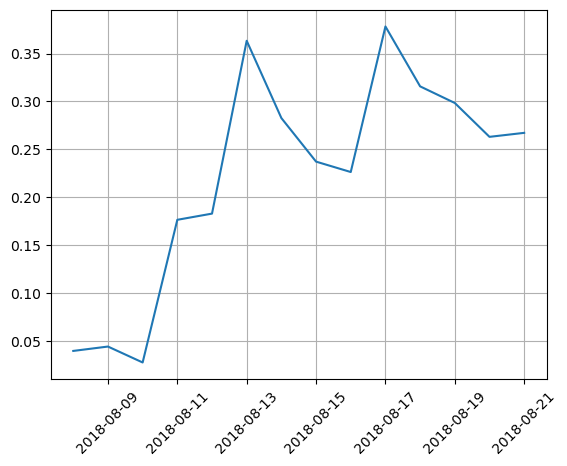

In [61]:
plt.plot(c.loc['A'].index, p_value_trend)
plt.xticks(rotation = 45)
plt.grid()

In [66]:
diff = (c.conversion.loc['B'] - c.conversion.loc['A']) * 100

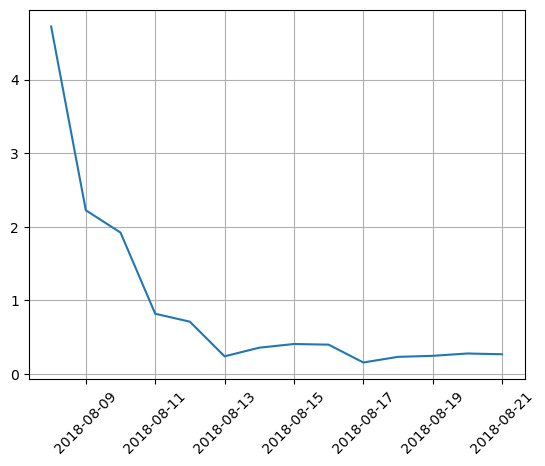

In [67]:
plt.plot(c.loc['A'].index, diff)
plt.xticks(rotation = 45)
plt.grid()

p-value по дням возрастает, с первых дней эксперемента он превышает уровень значимости 0.05 А разница в конверсии падает. На уровне значимости 5% мы подтверждаем нулевую гипотезу на текущих данных.  

Продолжаем анализ нашего теста о формулировках вопроса с ценой из первой практики. 
Теперь нас интересует, стали ли мы большое зарабатывать с заказов? Для того чтобы это узнать, нужно посмотреть на данные в столбце price. Но обратите внимание, что не все заказы были оплачены, оплаченные заказы имеют payed_status=30 и price>0.
- Как распределена стоимость заказов? 
- Как изменилась стоимость заказа в Б варианте? 
- Значимы ли эти изменения? 
- Как вы оценивали значимость? 
- Почему выбрали такой метод? 

Сделайте выводы об успешности АБ-теста. Почему получились такие результаты? Напишите свои гипотезы.
Данные лежат в файле trener_prices.xlsx.

In [74]:
df_test[(df_test.pay_status == 30) & (df_test.price > 0)].groupby('case_id').price.describe()

,count,mean,std,min,25%,50%,75%,max
case_id,,,,,,,,
A,2641.0,2627.527452,1594.586629,170.0,1549.0,2294.0,3259.0,12921.0
B,2629.0,1967.121719,1698.264773,1.0,800.0,1500.0,2500.0,12100.0


(array([ 557., 1084.,  612.,  213.,   99.,   40.,   19.,    8.,    4.,
           5.]),
 array([  170. ,  1445.1,  2720.2,  3995.3,  5270.4,  6545.5,  7820.6,
         9095.7, 10370.8, 11645.9, 12921. ]),
 <BarContainer object of 10 artists>)

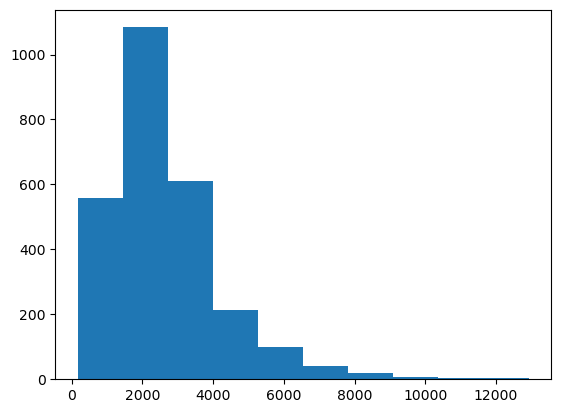

In [45]:
plt.hist(df_test[(df_test.pay_status == 30) & (df_test.price > 0) & (df_test.case_id == 'A')].price)

(array([1082.,  867.,  330.,  159.,   93.,   56.,   22.,   12.,    6.,
           2.]),
 array([1.00000e+00, 1.21090e+03, 2.42080e+03, 3.63070e+03, 4.84060e+03,
        6.05050e+03, 7.26040e+03, 8.47030e+03, 9.68020e+03, 1.08901e+04,
        1.21000e+04]),
 <BarContainer object of 10 artists>)

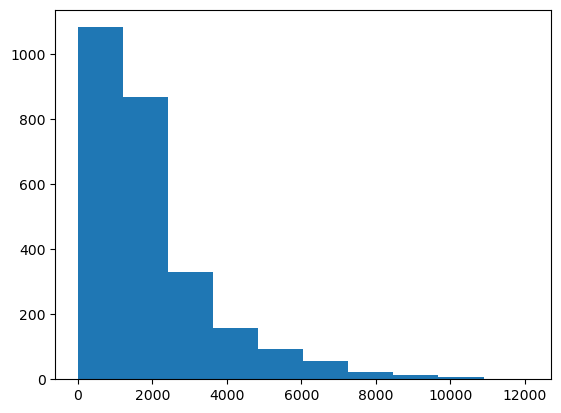

In [46]:
plt.hist(df_test[(df_test.pay_status == 30) & (df_test.price > 0) & (df_test.case_id == 'B')].price)

In [145]:
df_test[(df_test.pay_status == 30)]

,uid,case_id,received,price,pay_status,order_id,add_dt_day
15,576c9aee857f9f523bd81ae46bc6ae2d5101669bc59ff8...,A,2018-08-09 11:14:59,869.0,30.0,14235711.0,2018-08-09
21,71f91a6261d92ff905b4572e6baa15f2c44d1eb355fcda...,A,2018-08-13 18:51:14,1504.0,30.0,NaN,2018-08-13
28,3723a809e73af6b5bfa0114be30590e6175ca4529d73e8...,A,2018-08-20 19:57:08,1809.0,30.0,14380813.0,2018-08-20
29,ac45ad37992a0ccc55d23e0b935686590004310caa2393...,A,2018-08-14 22:48:42,2857.0,30.0,14305468.0,2018-08-10
32,1750e9320ea9142b15c568504600c605f6279d2760b89f...,A,2018-08-10 10:24:35,4566.0,30.0,NaN,2018-08-10
...,...,...,...,...,...,...,...
45225,9aa5fe7c9949edf008d0aa33aee8f6ba17aaa3789afb8a...,B,2018-08-15 13:27:51,3900.0,30.0,14312130.0,2018-08-15
45241,34a840dbfa0b71e13818c1ec4f7ff5e3ec387f8aa706fe...,B,2018-08-14 18:26:28,1700.0,30.0,14302775.0,2018-08-14
45244,502705488802cfe512a11c5e441aefdcba75b50b7dabd7...,B,2018-08-20 15:57:37,7200.0,30.0,14376938.0,2018-08-20
45250,64013cd69ee8b3cd638fdec25862f68cfce1c06c145319...,B,2018-08-11 12:50:27,3000.0,30.0,NaN,2018-08-11


Стоимость заказов в тестовой группе ниже, чем в контроьлной группе. Это видно и по средним показателям и по распределению цены  

На основании этих данных можем считать AB тест неуспешным, так как мы подтвердили нулевую гипотезу. 

In [154]:
N = 1500
a_price_mean = np.array(np.zeros(N))
b_price_mean = np.array(np.zeros(N))
df_a = df_test.query("case_id=='A'")[(df_test.pay_status == 30) & (df_test.price >= 0)].price
df_b = df_test.query("case_id=='B'")[(df_test.pay_status == 30) & (df_test.price >= 0)].price
len_a = len(df_a)
len_b = len(df_b)

/var/folders/9k/0q1vb1ws2g37rwtkrg8cnh7c0000gn/T/ipykernel_977/204255950.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_a = df_test.query("case_id=='A'")[(df_test.pay_status == 30) & (df_test.price >= 0)].price
/var/folders/9k/0q1vb1ws2g37rwtkrg8cnh7c0000gn/T/ipykernel_977/204255950.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_b = df_test.query("case_id=='B'")[(df_test.pay_status == 30) & (df_test.price >= 0)].price


In [155]:
for i in range(0, N):
    sample_a = random.choices(list(df_a), k = len_a)
    sample_b = random.choices(list(df_b), k = len_b)
    a_price_mean[i] = np.mean(sample_a)
    b_price_mean[i] = np.mean(sample_b)   

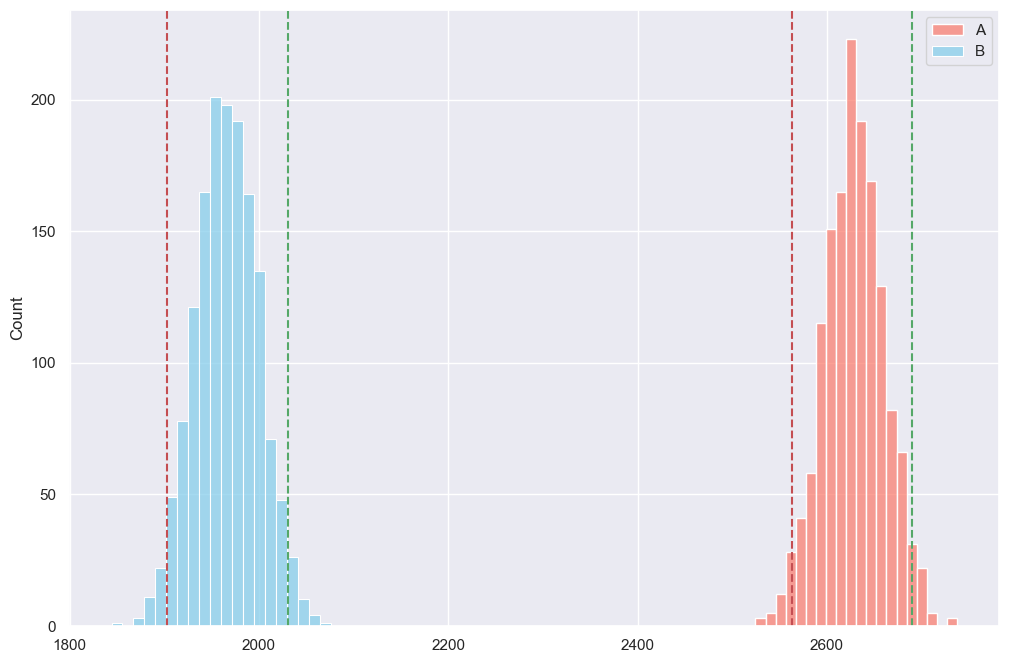

In [158]:
sns.set_theme()
fig, ax = plt.subplots(figsize = (12, 8))
sns.histplot(a_price_mean, ax=ax, label = 'A', color='salmon', bins = 20)
sns.histplot(b_price_mean, ax=ax, label = 'B', color='skyblue', bins = 20)
ax.axvline(np.percentile(a_price_mean, 2.5), color = 'r', linestyle = '--', )
ax.axvline(np.percentile(a_price_mean, 97.5), color = 'g', linestyle = '--', )
ax.axvline(np.percentile(b_price_mean, 2.5), color = 'r', linestyle = '--', )
ax.axvline(np.percentile(b_price_mean, 97.5), color = 'g', linestyle = '--', )

plt.legend()

In [163]:
mean_diff = np.array(np.zeros(N))
for i in range(0, N):
    a_sample = df_a.sample(100)
    b_sample = df_b.sample(100)
    mean_diff[i] = np.mean(b_sample) - np.mean(a_sample)
    

<AxesSubplot:ylabel='Count'>

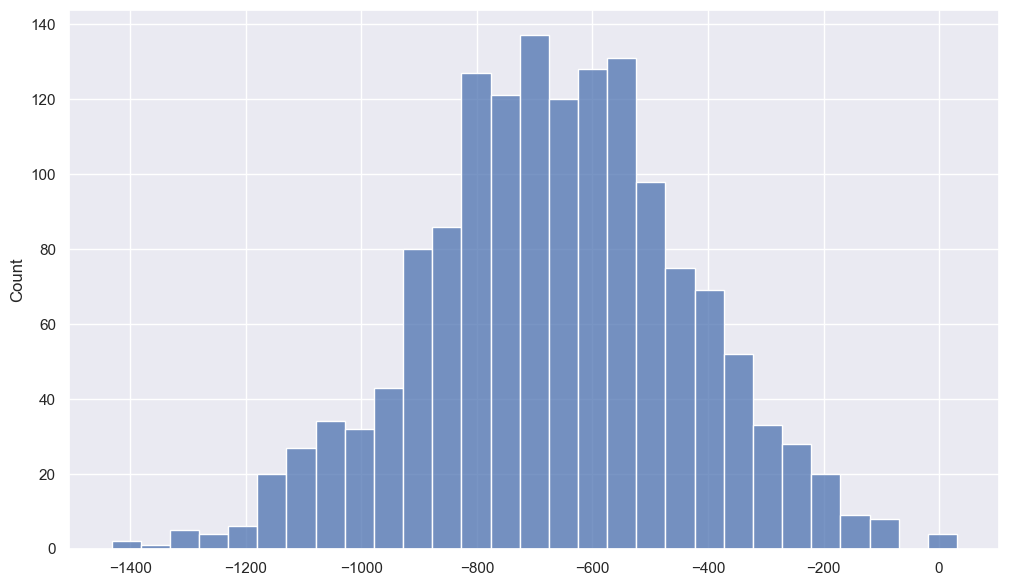

In [164]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.histplot(mean_diff, ax = ax)